# **Emission de CO2 par les véhicules - Regression Modelisation DL**

## 0. Import des modules et sous modules

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api
from scipy.stats import randint

In [6]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance

from plotly.subplots import make_subplots
from sklearn import preprocessing

In [46]:
from sklearn.linear_model import LinearRegression,RidgeCV, Lasso, LassoCV, ElasticNetCV, Ridge, SGDRegressor, ElasticNet 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor # regressor = DecisionTreeRegressor(random_state=0)
from sklearn.neural_network import MLPRegressor


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, r2_score, mean_squared_error, root_mean_squared_error

import tensorflow as tf
from tensorflow import keras
import os, sys

## 1. Import du DataSet et visualisation

In [14]:
data_final = pd.set_option('display.max_row', 111)
data_final = pd.set_option('display.max_column', 111)

In [17]:
data_final = pd.read_csv('df_final.csv')
df_final = data_final.copy()

In [20]:
df_final.head()

,Class_CO2,PuissanceMaximale_kW,masseVideEuroMax_kg,CO2_g_par_km,Marque_ALFA-ROMEO,Marque_ASTON MARTIN,Marque_AUDI,Marque_BENTLEY,Marque_BMW,Marque_CADILLAC,Marque_CHEVROLET,Marque_CITROEN,Marque_DACIA,Marque_DANGEL,Marque_FERRARI,Marque_FIAT,Marque_FORD,Marque_HONDA,Marque_HYUNDAI,Marque_INFINITI,Marque_JAGUAR,Marque_JAGUAR LAND ROVER LIMITED,Marque_JEEP,Marque_KIA,Marque_LADA,Marque_LAMBORGHINI,Marque_LANCIA,Marque_LAND ROVER,Marque_LEXUS,Marque_LOTUS,Marque_MASERATI,Marque_MAYBACH,Marque_MAZDA,Marque_MERCEDES,Marque_MERCEDES AMG,Marque_MERCEDES-BENZ,Marque_MINI,Marque_MITSUBISHI,Marque_NISSAN,Marque_OPEL,Marque_PEUGEOT,Marque_PORSCHE,Marque_QUATTRO,Marque_RENAULT,Marque_RENAULT TECH,Marque_ROLLS-ROYCE,Marque_SEAT,Marque_SKODA,Marque_SMART,Marque_SSANGYONG,Marque_SUBARU,Marque_SUZUKI,Marque_TOYOTA,Marque_VOLKSWAGEN,Marque_VOLVO,Carburant_C_autre,Carburant_ES,Carburant_GO,Hybride_non,Hybride_oui,BoîteDeVitesse_Auto,BoîteDeVitesse_BV_autre,BoîteDeVitesse_M,Carrosserie_BERLINE,Carrosserie_BREAK,Carrosserie_CABRIOLET,Carrosserie_COMBISPACE,Carrosserie_COUPE,Carrosserie_MINIBUS,Carrosserie_MINISPACE,Carrosserie_MONOSPACE,Carrosserie_MONOSPACE COMPACT,Carrosserie_TS TERRAINS/CHEMINS,gamme_ECONOMIQUE,gamme_INFERIEURE,gamme_LUXE,gamme_MOY-INF,gamme_MOY-SUPER,gamme_SUPERIEURE
0,E,0.544329,-1.809856,182.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,C,0.071365,-1.667545,136.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,C,-0.466095,-1.667545,134.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,C,-0.466095,-1.667545,134.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,C,0.071365,-1.667545,139.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [23]:
df_final = df_final.drop('Class_CO2', axis = 1) # suppression de la variable cible "Class_CO2" destinée à la classification

In [27]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98454 entries, 0 to 98453
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PuissanceMaximale_kW              98454 non-null  float64
 1   masseVideEuroMax_kg               98454 non-null  float64
 2   CO2_g_par_km                      98454 non-null  float64
 3   Marque_ALFA-ROMEO                 98454 non-null  bool   
 4   Marque_ASTON MARTIN               98454 non-null  bool   
 5   Marque_AUDI                       98454 non-null  bool   
 6   Marque_BENTLEY                    98454 non-null  bool   
 7   Marque_BMW                        98454 non-null  bool   
 8   Marque_CADILLAC                   98454 non-null  bool   
 9   Marque_CHEVROLET                  98454 non-null  bool   
 10  Marque_CITROEN                    98454 non-null  bool   
 11  Marque_DACIA                      98454 non-null  bool   
 12  Marq

## 2. TrainTest 

In [32]:
# Créons un objet y contenant la variable cible CO2_g_par_km et un object X contenant le reste des variables
X = df_final.drop('CO2_g_par_km', axis=1)
y = df_final['CO2_g_par_km']

In [35]:
# Séparons les données en un ensemble d'apprentissage (X_train, y_train) et un ensemble de test (X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\tchar\AppData\Local\Temp\ipykernel_25432\232896332.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='y_train')
C:\Users\tchar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tchar\AppData\Local\Temp\ipykernel_25432\232896332.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar 

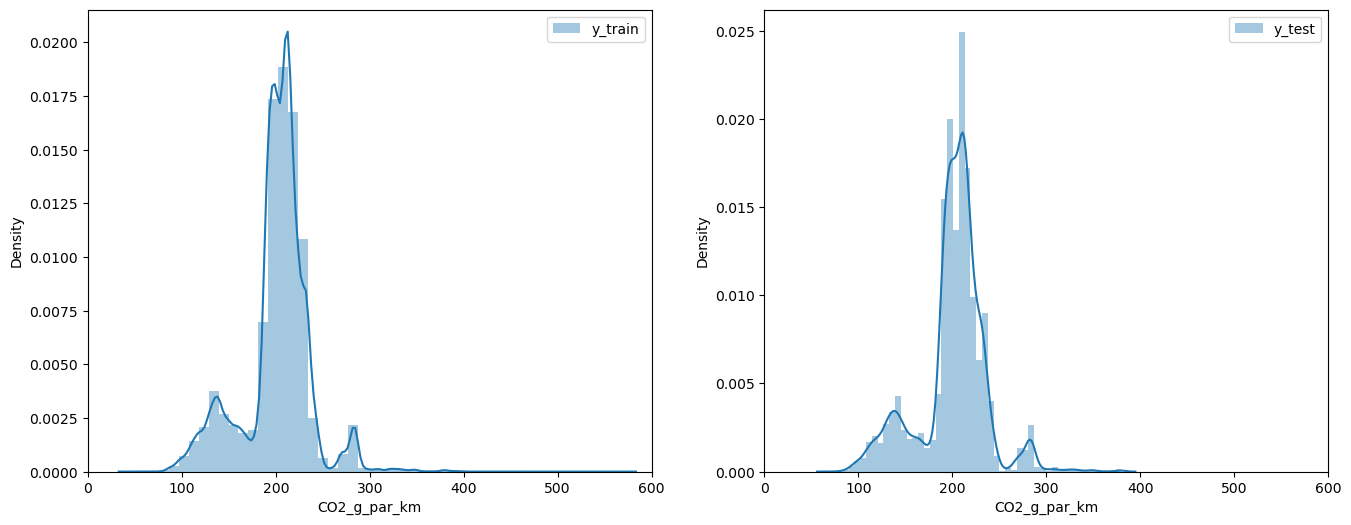

In [38]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
sns.distplot(y_train, label='y_train')
plt.xlim(0, 600)
plt.legend()

#plt.plot(t2, f(t2), "k")

plt.subplot(122)
sns.distplot(y_test, label='y_test')
plt.xlim(0, 600)
plt.legend()

## 3. Utilisation du Deep Learning 

##### Dans cette partie du projet, nous utilisons les techniques de Deep Leraning pour prédire l'émission de CO2. Nous utilisons un modèle séquentiel qui nous permet d'empiler des couches de neurones et qui necessite de préciser la forme des données d'entrée. Après avoir préciser les données d'entrée, nous utilisont 3 couches de 64 neurones chacune et une dernière couche de sortie avec le nombre de classe à prédire. la fonction d'activation "relu" est utilisée pour les 4 couches de 100, 64, 32, 16 neurones. ici, il s'agit d'un problème de regression, c'est à dire prédire un scalaire. Nous avons donc une couche de sortie avec un neurone pour la prédiction de cette valeur. Pour compiler le modèle, nous utilisons comme optimizeur l'algorithme d'optimisation : Adaptive Moment Estimation "adam". Il s'agit d'un algorithme à taux d'apprentissage adaptatif. Cela signifie qu'il ajuste dynamiquement le taux d'apprentissage pour chaque paramètre individuel d'un modèle, plutôt que d'utiliser un taux d'apprentissage global unique. Nous utilisons comme fonction de perte la MSE qui évalue la moyenne des erreurs quadratiques, représentant la différence quadratique moyenne entre les valeurs estimées par le modèle et les valeurs réelles. Elle indique l'importance de la part de la variance qui peut être expliquée par les variables indépendantes. Plus la variance peut être expliquée, meilleur est le modèle de régression. En terme de métrics nous utilisons la MSE et la mae, mais nous preterons plus attentionn à la MSE qui pour nous est plus adaptée à notre problematique.


##### Nous avons entrainé notre modèle sur des paquets (batch_size) de 64 sur 500 epoch. Nous obtenons un mse de 117 sur les echantillons de train et 128.85 sur les echantillons de test. Il s'agit icic de bon resultats puisque ces resultats sont comparables à ceux obtenus par les modèles RandomForest (mse train: 94, mse test : 114), l'arbre de décision (mse train: 90, mse test : 129), GradientBoosting (mse train: 142, mse test : 146) et le KNN (mse train: 113, mse test : 127).

##### Lorsque que nous supperposons les données brutes et les données prédictes, nous obtenons les même comportement que ceux obtenus avec les modèles RandomForest , l'arbre de décision , GradientBoosting  et le KNN.

### 3.1 Construction du Modèle

In [56]:
def get_model(shape):

    model_DP = keras.models.Sequential()
    model_DP.add(keras.layers.Input(shape, name = "InputLayer"))
    model_DP.add(keras.layers.Dense(100, activation = 'relu', name='Dense_n1'))
    model_DP.add(keras.layers.Dense(64, activation = 'relu', name='Dense_n2'))
    model_DP.add(keras.layers.Dense(32, activation = 'relu', name='Dense_n3'))
    model_DP.add(keras.layers.Dense(16, activation = 'relu', name='Dense_n4'))
    model_DP.add(keras.layers.Dense(1, name='Output'))

    model_DP.compile(optimizer = 'adam',
                     loss      = 'mse',
                     metrics   = ['mse', 'mae'])
    return model_DP   

### 3.2 Paramètres du Modèle

In [58]:
model_DP = get_model((77,))
model_DP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 100)               7800      
                                                                 
 Dense_n2 (Dense)            (None, 64)                6464      
                                                                 
 Dense_n3 (Dense)            (None, 32)                2080      
                                                                 
 Dense_n4 (Dense)            (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 16,889
Trainable params: 16,889
Non-trainable params: 0
_________________________________________________________________


### 3.3 Conversion des données d'entrées en tableau

In [60]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

### 3.4 Entrainement du Modèle

In [63]:
history = model_DP.fit(X_train,
                    y_train,
                    epochs = 500,
                    batch_size = 64,
                    verbose = 1,
                    validation_data = (X_test, y_test))

Epoch 1/500
1231/1231 [==============================] - 4s 2ms/step - loss: 2313.1174 - mse: 2313.1174 - mae: 22.2154 - val_loss: 243.1457 - val_mse: 243.1457 - val_mae: 10.5563
Epoch 2/500
1231/1231 [==============================] - 3s 2ms/step - loss: 242.6717 - mse: 242.6717 - mae: 10.2416 - val_loss: 221.5014 - val_mse: 221.5014 - val_mae: 9.7929
Epoch 3/500
1231/1231 [==============================] - 2s 2ms/step - loss: 231.0629 - mse: 231.0629 - mae: 10.0360 - val_loss: 208.7059 - val_mse: 208.7059 - val_mae: 9.7567
Epoch 4/500
1231/1231 [==============================] - 2s 2ms/step - loss: 222.4537 - mse: 222.4537 - mae: 9.8686 - val_loss: 215.0853 - val_mse: 215.0853 - val_mae: 9.7615
Epoch 5/500
1231/1231 [==============================] - 3s 2ms/step - loss: 215.0626 - mse: 215.0626 - mae: 9.7435 - val_loss: 198.8077 - val_mse: 198.8077 - val_mae: 9.5698
Epoch 6/500
1231/1231 [==============================] - 3s 2ms/step - loss: 210.8074 - mse: 210.8074 - mae: 9.6592 - v

### 3.5 Evaluation du Modèle

In [67]:
score = model_DP.evaluate(X_test, y_test, verbose = 1)

print('X_test \ loss                      : {:5.4f}'.format(score[0]))
print('X_test \ mse                       : {:5.4f}'.format(score[1]))
print('X_test \ mae                       : {:5.4f}'.format(score[2]))
#print('X_test \ mean_squared_error        : {:5.4f}'.format(score[3]))

616/616 [==============================] - 1s 1ms/step - loss: 133.9391 - mse: 133.9391 - mae: 8.0118
X_test \ loss                      : 133.9391
X_test \ mse                       : 133.9391
X_test \ mae                       : 8.0118


In [69]:
df_DL = pd.DataFrame(data=history.history)
display(df_DL)

,loss,mse,mae,val_loss,val_mse,val_mae
0,2313.117432,2313.117432,22.215393,243.145706,243.145706,10.556298
1,242.671661,242.671661,10.241553,221.501404,221.501404,9.792942
2,231.062866,231.062866,10.036022,208.705887,208.705887,9.756730
3,222.453735,222.453735,9.868593,215.085342,215.085342,9.761517
4,215.062561,215.062561,9.743516,198.807678,198.807678,9.569791
...,...,...,...,...,...,...
495,117.778877,117.778877,7.513723,133.777618,133.777618,8.096269
496,117.513359,117.513359,7.501423,131.085434,131.085434,7.946670
497,117.788033,117.788033,7.536112,131.517334,131.517334,7.912723
498,117.674019,117.674019,7.505914,135.172775,135.172775,8.161677


In [71]:
print("min(val_mse) : {:.4f}".format(min(history.history["val_mse"])))
print("min(mse) : {:.4f}".format(min(history.history["mse"])))
#print("min(val_mean_squared_error) : {:.4f}".format(min(history.history["val_mean_squared_error"])))


min(val_mse) : 128.8503
min(mse) : 117.2510


In [82]:
ypred_train_DL =  model_DP.predict(X_train)
ypred_test_DL =  model_DP.predict(X_test)

C:\Users\tchar\AppData\Local\Temp\ipykernel_25432\2098494022.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, hist=False, label='y_train brut DL')
C:\Users\tchar\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tchar\AppData\Local\Temp\ipykernel_25432\2098494022.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a fig

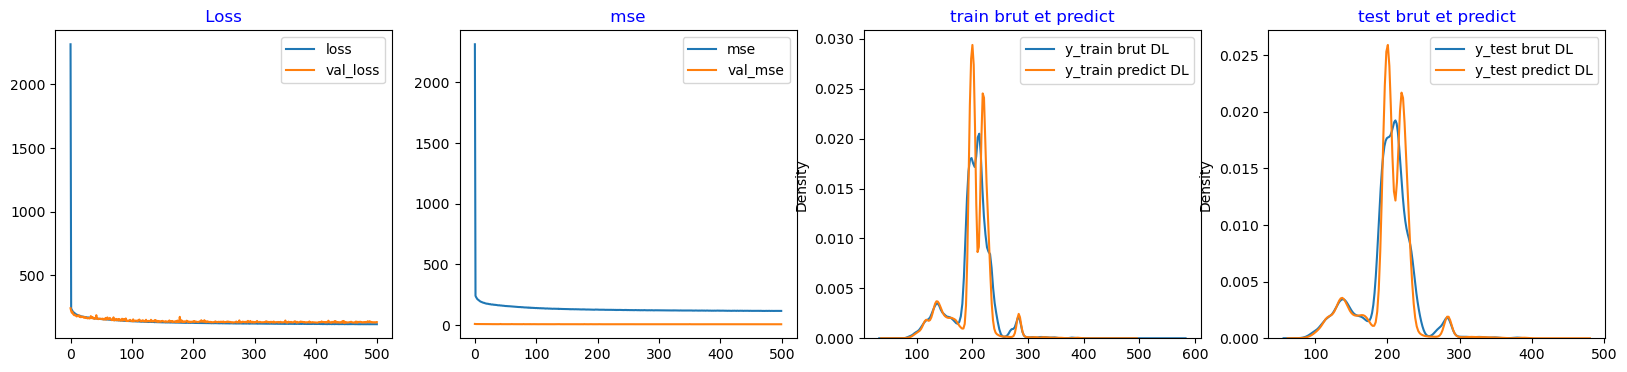

In [84]:
plt.figure(figsize=(20, 4))

plt.subplot(141)
plt.plot(df_DL['loss'], label='loss')
plt.plot(df_DL['val_loss'], label='val_loss')
plt.title(" Loss ", fontdict={"color" : "blue"})
plt.legend()

plt.subplot(142)
plt.plot(df_DL['mse'], label='mse')
plt.plot(df_DL['val_mae'], label='val_mse')
plt.title(" mse ", fontdict={"color" : "blue"})
plt.legend()

plt.subplot(143)
sns.distplot(y_train, hist=False, label='y_train brut DL')
sns.distplot(ypred_train_DL, hist=False, label='y_train predict DL')
plt.title("train brut et predict", fontdict={"color" : "blue"})
plt.legend()

plt.subplot(144)
sns.distplot(y_test, hist=False, label='y_test brut DL')
sns.distplot(ypred_test_DL, hist=False, label='y_test predict DL')
plt.title("test brut et predict", fontdict={"color" : "blue"})
plt.legend()